In [80]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
import time
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt

# Datasets

In [3]:
def dataset_1():
    X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        n_classes=2,
        random_state=42
    )

    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    X = discretizer.fit_transform(X)
    return X, y

In [9]:
def dataset_2():
    X = np.random.randint(0, 2, (1000, 100))
    y = ((X[:, 0] ^ X[:, 1]) | (X[:, 2] & X[:, 3] & X[:, 4])).astype(int)
    return X, y

In [21]:
def dataset_3():
    n = 1000
    p = 14
    k = 6

    X = np.random.randn(n, p)
    chisq_median = chi2.median(k)
    y = ((X[:, :k]**2).sum(axis=1) > chisq_median).astype(int)

    return X, y

In [22]:
def gini(X, y):
    data = []
    for col in range(X.shape[1]):
        temp_df = pd.DataFrame({'X': X[:, col], 'y': y})
        x_y_count = temp_df.groupby(['X', 'y'])['y'].count()
        x_count = temp_df.groupby('X').count()['y']
        gini_vals = 1 - ((x_y_count / x_count)**2).groupby('X').sum()
        gini_val = (x_count * gini_vals / X.shape[0]).sum()
        data.append({'feature': col, 'gini': gini_val})
    return pd.DataFrame(data)

# Filters

In [28]:
X, y = dataset_1()
X, y = dataset_2()
# X, y = dataset_3()

In [29]:
gini(X, y).sort_values('gini')

,feature,gini
3,3,0.483845
2,2,0.488499
4,4,0.490269
58,58,0.491385
88,88,0.491594
...,...,...
51,51,0.493727
78,78,0.493728
63,63,0.493728
66,66,0.493728


# Wrapper

In [34]:
X, y = dataset_1()
# X, y = dataset_2()
# X, y = dataset_3()

In [35]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel='linear')
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe.fit(X, y)
rfe.ranking_

array([1, 2, 1, 1, 1, 5, 1, 3, 4, 6])

## Evaluate Models

In [82]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = SVC()
model = RandomForestClassifier()
X, y = dataset_1()
feature_mask = [0, 2, 3, 4, 6]
relevant_mask = [0, 1, 2, 3, 4]

In [83]:
def get_metric_data(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    return ({
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

accuracy, precision, recall and F1 score

In [86]:
def eval_model(model, X, y, feature_mask, relevant_mask):
    def get_metric_data(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)

        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        return ({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    kf = KFold(n_splits=50)
    data_full = []
    data_chosen = []
    data_relevant = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        data_full.append(get_metric_data(model, x_train, x_test, y_train, y_test))
        data_chosen.append(get_metric_data(model, x_train[:, feature_mask], x_test[:, feature_mask], y_train, y_test))
        data_relevant.append(get_metric_data(model, x_train[:, relevant_mask], x_test[:, relevant_mask], y_train, y_test))
    data_full = pd.DataFrame(data_full)
    data_chosen = pd.DataFrame(data_chosen)
    data_relevant = pd.DataFrame(data_relevant)

    # plot results
    fig, axs = plt.subplots(3, 4, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    datasets = [
        (data_full, 'Full Feature Set', 'firebrick'),
        (data_chosen, 'Chosen Feature Set', 'gold'),
        (data_relevant, 'Relevant Feature Set', 'seagreen')
    ]

    x_limits = {}
    for col_idx, metric in enumerate(metrics):
        min_val = min(data_full[metric].min(), 
                    data_chosen[metric].min(), 
                    data_relevant[metric].min())
        max_val = max(data_full[metric].max(),
                    data_chosen[metric].max(),
                    data_relevant[metric].max())
        x_limits[col_idx] = (min_val - 0.02, max_val + 0.02)

    for row_idx, (data, label, color) in enumerate(datasets):
        for col_idx, metric in enumerate(metrics):
            sns.histplot(
                data=data,
                x=metric,
                ax=axs[row_idx, col_idx],
                color=color,
                kde=True,
                bins=15,
                alpha=0.4
            )
            
            axs[row_idx, col_idx].set_xlim(x_limits[col_idx])
            
            axs[row_idx, col_idx].grid(True, linestyle='--', alpha=0.6)
            
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(label, fontsize=12, fontweight='bold')
                
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(metric, fontsize=14, fontweight='bold')

    for col_idx, metric in enumerate(metrics):
        axs[2, col_idx].set_xlabel(f'{metric} Value', fontsize=10)

    plt.suptitle('Performance Metrics Distribution Comparison', y=1.02, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

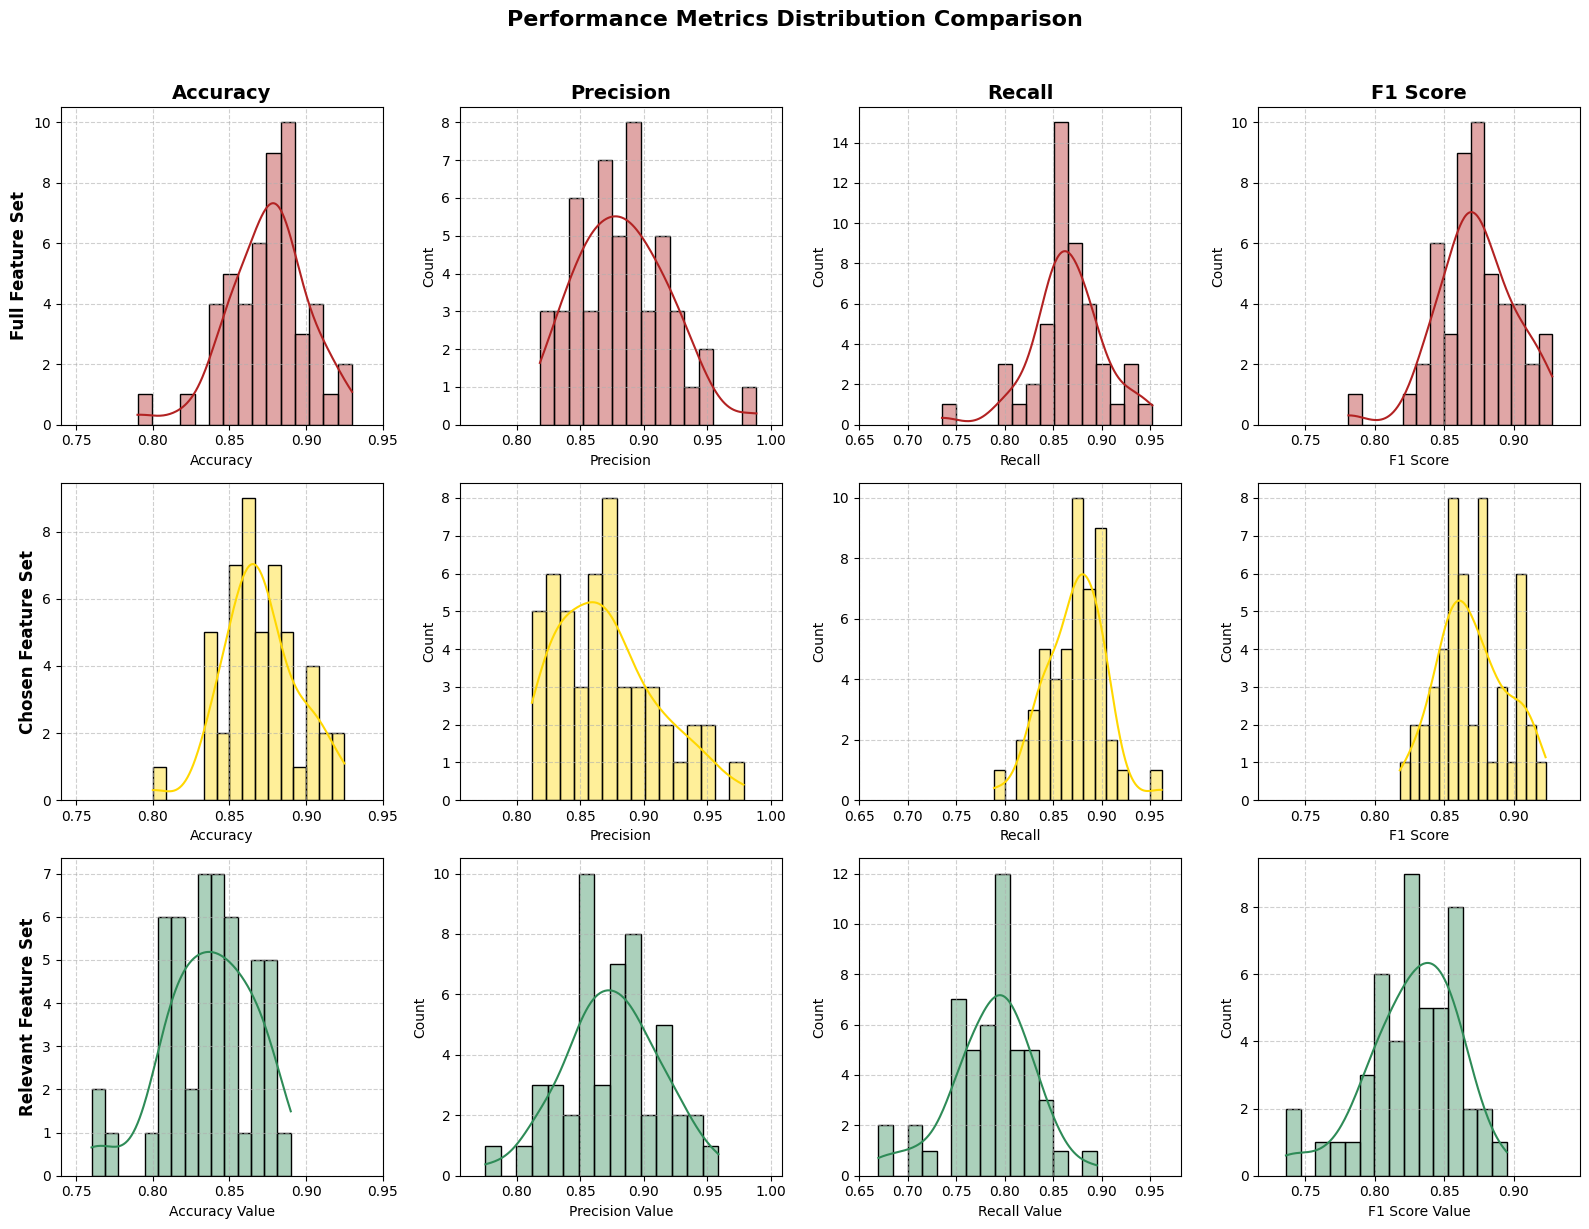

In [87]:
eval_model(model,  X, y, [0, 2, 3, 4, 6], [0, 1, 2, 3, 4])